In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import pickle as pkl
import math
import glob
import os

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb

import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-2]+['eval','cleaned','']))
from params_opt_maps import *

In [2]:
path_data='/om2/user/khrovati/data/cross_system_integration/'
path_names=path_data+'names_parsed/'
path_fig=path_data+'figures/'

In [3]:
# Names
model_map=pkl.load(open(path_names+'models.pkl','rb'))
param_map=pkl.load(open(path_names+'params.pkl','rb'))
metric_map=pkl.load(open(path_names+'metrics.pkl','rb'))
dataset_map=pkl.load(open(path_names+'datasets.pkl','rb'))
metric_meaning_map=pkl.load(open(path_names+'metric_meanings.pkl','rb'))
metric_map_rev=dict(zip(metric_map.values(),metric_map.keys()))
dataset_map_rev=dict(zip(dataset_map.values(),dataset_map.keys()))
system_map=pkl.load(open(path_names+'systems.pkl','rb'))
params_opt_map=pkl.load(open(path_names+'params_opt_model.pkl','rb'))
params_opt_gene_map=pkl.load(open(path_names+'params_opt_genes.pkl','rb'))
param_opt_vals=pkl.load(open(path_names+'optimized_parameter_values.pkl','rb'))
cell_type_map=pkl.load(open(path_names+'cell_types.pkl','rb'))

# cmap
model_cmap=pkl.load(open(path_names+'model_cmap.pkl','rb'))
obs_col_cmap=pkl.load(open(path_names+'obs_col_cmap.pkl','rb'))
metric_background_cmap=pkl.load(open(path_names+'metric_background_cmap.pkl','rb'))

In [4]:
dataset='pancreas_conditions_MIA_HPAP2'

In [5]:
# Load data
path_integration=f'{path_data}eval/{dataset}/'
run=pkl.load(open(f'{path_integration}integration_summary/top_settings.pkl','rb'))['saturn']['mid_run']
path_run=f'{path_integration}integration/{run}/'
embed=sc.read(path_run+'embed.h5ad')
args=pkl.load(open(path_run+'args.pkl','rb'))

In [7]:
# Prepare data
# The system cl will be ordered automatically as cl is number and na system is alphabetical
embed.obs['leiden_system_mm']=embed.obs.apply(
    lambda x: x['leiden_system'].split('_')[1] if x.system=='0' else 'Human',axis=1)
embed.obs['leiden_system_hs']=embed.obs.apply(
    lambda x: x['leiden_system'].split('_')[1] if x.system=='1' else 'Mouse',axis=1)
embed.obs['mm_study_parsed']=\
    embed.obs['mm_study'].cat.add_categories('Human').fillna('Human').map({
    'spikein_drug':'Chem', 
    'STZ':'mSTZ', 
    'Human':'Human', 
    'Fltp_adult':'4m', 
    'VSG':'db/db', 
    'Fltp_P16':'P16', 
    'Fltp_2y':'Aged', 
    'NOD':'5wNOD', 
    'NOD_elimination':'8-16wNOD'
})
embed.obs['cell_type_parsed']=embed.obs[args.group_key].map(cell_type_map[dataset])
embed.obs['system_parsed']=embed.obs[args.system_key].map(system_map[dataset])

col_na_system={
    'mm_study_parsed':'Human',
    'leiden_system_mm':'Human',
    'leiden_system_hs':'Mouse'
}
# Cmap for 'other system' categ in lightgray
for col,system in col_na_system.items():
    if embed.obs[col].dtype.name!='category':      
        embed.obs[col]=pd.Categorical(values=embed.obs[col],
                                      categories=sorted(embed.obs[col].unique()),
                                      ordered=True)
    obs_col_cmap[dataset][col]=sc.pl._tools.scatterplots._get_palette(embed, col)
    obs_col_cmap[dataset][col][system]='lightgray'

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packa

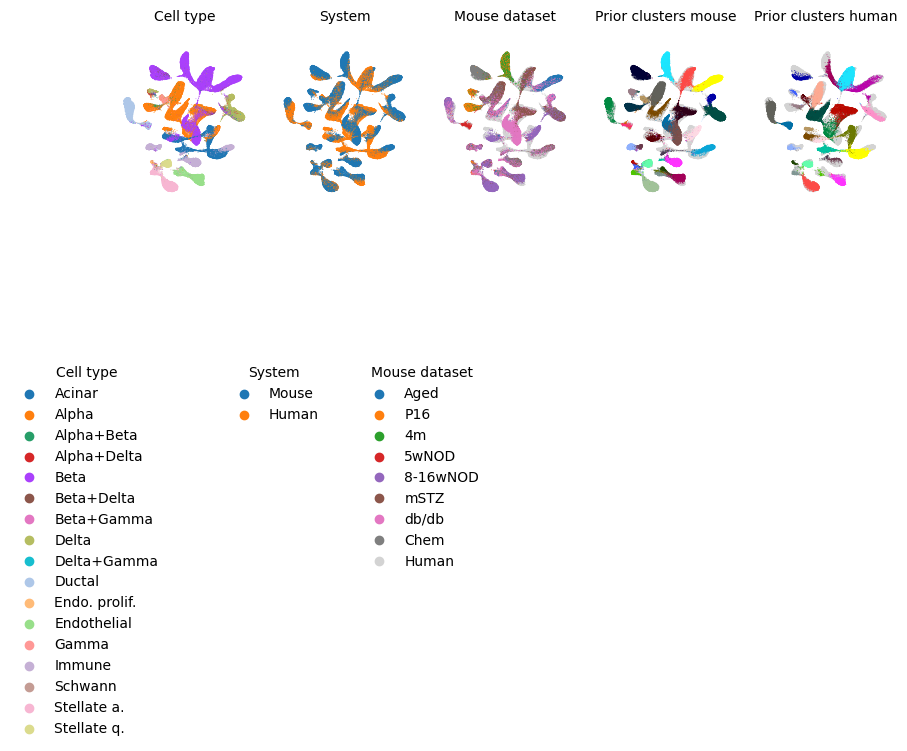

In [12]:
ncol=5
system_col='System'
ct_col='Cell type'
fig,axs=plt.subplots(1,ncol,figsize=(2*ncol,2))
for icol,(col_name,col) in enumerate(zip(
    [ct_col,system_col,'Mouse dataset','Prior clusters mouse','Prior clusters human'],
    ['cell_type_parsed','system_parsed','mm_study_parsed','leiden_system_mm','leiden_system_hs'])):

    # Set cmap and col val names
    if col_name==system_col:
        cmap=obs_col_cmap[dataset][args.system_key]
        cmap={system_map[dataset][k]:v for k,v in cmap.items()}
    elif col_name==ct_col:
        cmap=obs_col_cmap[dataset][args.group_key]
        cmap={cell_type_map[dataset][k]:v for k,v in cmap.items()}
    else:
        cmap=obs_col_cmap[dataset][col] if col in obs_col_cmap[dataset] else None

    # Plot
    ax=axs[icol]
    if col in col_na_system:
        na_system_parsed=col_na_system[col]
        cell_order=list(embed.obs.query('system_parsed==@na_system_parsed').index) +\
                    list(embed.obs.query('system_parsed!=@na_system_parsed').index)
    else:
        cell_order=embed.obs_names

    sc.pl.umap(embed[cell_order,:],color=col,ax=ax,show=False,
              palette=cmap, frameon=False,title='')

    # Make pretty
    ax.set_title(col_name+'\n',fontsize=10)
    
    if 'Prior clusters' in col_name:
        ax.get_legend().remove()
    else:
        ax.legend(bbox_to_anchor=(0.4,-1),frameon=False, ncol=1,title=col_name)

fig.set(facecolor = (0,0,0,0))
plt.savefig(path_fig+f'saturn_prior-embed_cl-umap.pdf',
            dpi=300,bbox_inches='tight')
plt.savefig(path_fig+f'saturn_prior-embed_cl-umap.png',
            dpi=300,bbox_inches='tight')